# **Energy Consumption Time Series Forecast**

Project aim:

> This task aims to perform Time Series Forecasting on the Energy Consumption Dataset provided. Using the dataset, we are supposed to build a timeseries model and make predictions of the gas, electricity and water consuption using the test dataset.

# Importing Packages/Dataset

In [2]:
!pip install pandas-profiling

In [3]:
from tqdm import tqdm # Use this to track how much time each iter of a for loop takes
import warnings # Statsmodels likes to throw out warnings. Some of them are important, some are not
from statsmodels.tools.sm_exceptions import *
from collections import defaultdict 
from statsmodels.api import load # load serialized models
from joblib import Parallel, delayed # Parallelise our grid search
# Statistical Analysis
## General
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm

## Time Series
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.tsa.stattools import kpss

## Model Validation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error


# Graphical Plots
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df = pd.read_csv("Energy Consumption Dataset.csv")

# Exploratory Data Analysis

In [4]:
df.head()

,DATE,Gas Consumption (tons),Electricity Consumption (MWh),Water Consumption (tons)
0,1/1/1990,18.0,725.1,548.8
1,1/2/1990,15.8,706.7,640.7
2,1/3/1990,17.3,624.5,511.1
3,1/4/1990,18.9,574.7,515.3
4,1/5/1990,22.0,553.2,488.4


In [5]:
df.isna().sum()

DATE                             0
Gas Consumption (tons)           0
Electricity Consumption (MWh)    0
Water Consumption (tons)         0
dtype: int64

In [6]:
df.describe()

,Gas Consumption (tons),Electricity Consumption (MWh),Water Consumption (tons)
count,397.000000,397.000000,397.000000
mean,23.785139,888.472544,484.953652
std,4.903452,153.877594,133.908863
min,11.600000,553.200000,44.400000
25%,20.200000,771.100000,384.400000
50%,23.500000,897.800000,487.400000
75%,27.900000,1005.200000,580.200000
max,46.000000,1294.000000,811.000000


<font size = 6>

**Profile Report**

<font size = 3>

As we can see from the report, none of the features are very correlated to each other. Gas-Electricity and Electricity-Water have weak positive relationship while Gas-Water has a weak negative relationship.

In [7]:
from pandas_profiling import ProfileReport

prof = ProfileReport(df, explorative=True)

print("Summary")
print(f"Gas-Electricity = {df.corr()['Gas Consumption (tons)']['Electricity Consumption (MWh)']}")
print(f"Electricity-Water = {df.corr()['Electricity Consumption (MWh)']['Water Consumption (tons)']}")
print(f"Gas-Water = {df.corr()['Gas Consumption (tons)']['Water Consumption (tons)']}")


Summary
Gas-Electricity = 0.13505631764008444
Electricity-Water = 0.2220019044818366
Gas-Water = -0.38781340470929854


C:\Users\Fitri\AppData\Local\Temp\ipykernel_8532\3992481250.py:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport
C:\Users\Fitri\AppData\Local\Temp\ipykernel_8532\3992481250.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(f"Gas-Electricity = {df.corr()['Gas Consumption (tons)']['Electricity Consumption (MWh)']}")
C:\Users\Fitri\AppData\Local\Temp\ipykernel_8532\3992481250.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(f"Electricity-Water = {df.corr()['Electricity Consumption (MWh)']['Water Consumptio

<font size = 6>

**Timespan of Dataset**

In [8]:
print(f'Start Date:{df["DATE"].min()}\nEnd Date: {df["DATE"].max()}')

Start Date:1/1/1990
End Date: 1/9/2022


Before performing a time series visualisation, I will need to make date the index of the dataset.

In [9]:
df["DATE"] = pd.to_datetime(df["DATE"], format="%d/%m/%Y")
df.set_index('DATE', inplace=True)

Outliers in Series (First 5)


,Gas Consumption (tons),Electricity Consumption (MWh),Water Consumption (tons)
DATE,,,
2014-02-01,46.0,1044.2,44.4


No. of Outliers: 1


<Figure size 1000x600 with 0 Axes>

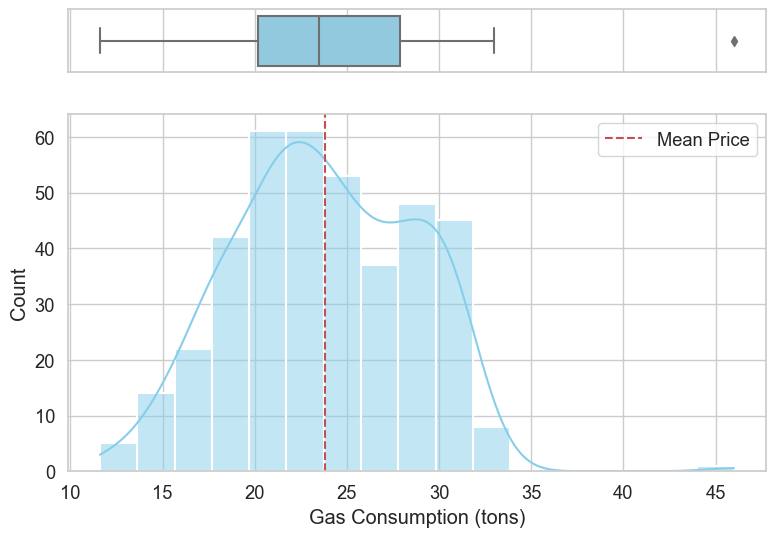

No Outliers


<Figure size 1000x600 with 0 Axes>

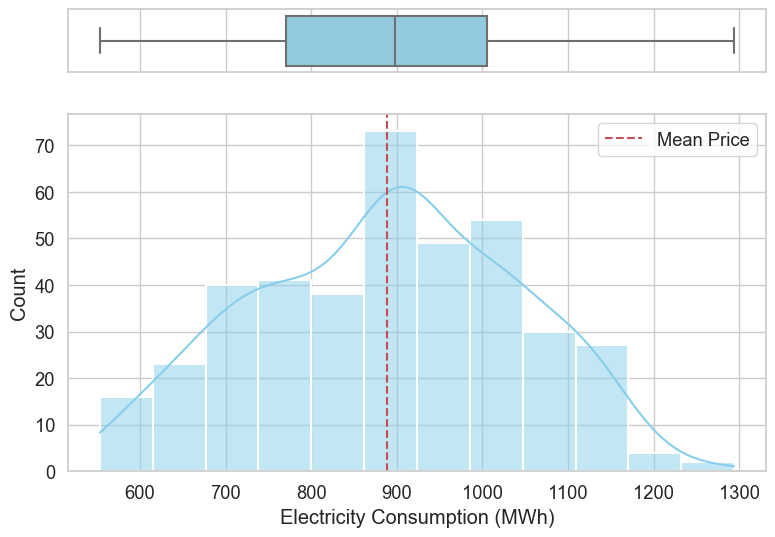

Outliers in Series (First 5)


,Gas Consumption (tons),Electricity Consumption (MWh),Water Consumption (tons)
DATE,,,
2014-02-01,46.0,1044.2,44.4


No. of Outliers: 1


<Figure size 1000x600 with 0 Axes>

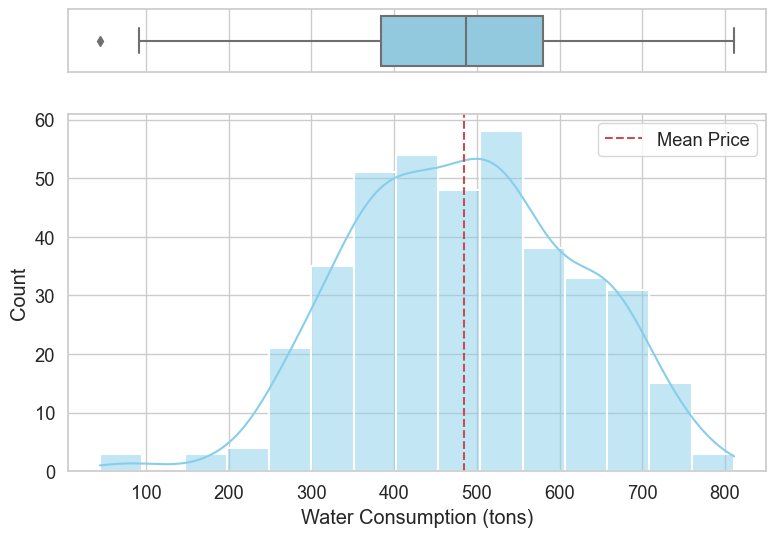

In [19]:
features = ['Gas Consumption (tons)', 'Electricity Consumption (MWh)', 'Water Consumption (tons)']

for feature in features:
    sort = True
    deskew = True
    col = df[feature]
    Q3 = col.quantile(0.75)
    Q1 = col.quantile(0.25)
    IQR = Q3 - Q1
    UpperFence = Q3 + 1.5 * IQR
    LowerFence = Q1 - 1.5 * IQR
    mask = (col > UpperFence) | (col < LowerFence)
    outlier_df = df[mask]
    if len(outlier_df) == 0:
        print("No Outliers")
    else:
        print("Outliers in Series (First 5)")
        display(outlier_df.head())
        print("No. of Outliers:", len(outlier_df))
    sns.set(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(10, 6))
    # boxplot and histplot together
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize = (9, 6))
    sns.boxplot(x= feature, data = df, ax=ax_box, color='skyblue')
    sns.histplot(x= feature , ax = ax_hist, kde=True, color='skyblue', edgecolor='white', linewidth=1.5, data= df)

    # find mean value
    mean = df[feature].mean()

    # create mean line on histogram 
    ax_hist.axvline(mean, color='r', linestyle='--', label="Mean Price")
    ax_hist.legend()
    ax_box.set(xlabel='')
    plt.show()



# **Time Series Analysis**

## Dickey Fuller Test for Stationarity Series
To model a time-series using ARMA model, we need to ensure the time-series is stationary, that is the the mean, variance and covariance does not vary with time.

To verify stationarity, we will be utilising Augmented Dickey Test at Significant Value, where 

In [11]:
def adfuller_test(data):
    for feature in features:
        print(f'ADF Results for {feature} feature')
        print('-'*40)
        print(f'ADF Statistic: {adfuller(data[feature])[0]}')
        print(f'p-value: {round(adfuller(data[feature])[1], 5)}')
        print('Level of significance: 5%')

        # check if p value is less than 0.05, if so, the data is stationary
        if adfuller(data[feature])[1] < 0.05:
            print('Null hypothesis rejected, data is stationary')
        else:
            print('Null hypothesis accepted, data is not stationary')
        print('\n')
adfuller_test(df)

ADF Results for Gas Consumption (tons) feature
----------------------------------------
ADF Statistic: -3.4043743333182723
p-value: 0.01081
Level of significance: 5%
Null hypothesis rejected, data is stationary


ADF Results for Electricity Consumption (MWh) feature
----------------------------------------
ADF Statistic: -2.2569805495925452
p-value: 0.18622
Level of significance: 5%
Null hypothesis accepted, data is not stationary


ADF Results for Water Consumption (tons) feature
----------------------------------------
ADF Statistic: -4.684845541682445
p-value: 9e-05
Level of significance: 5%
Null hypothesis rejected, data is stationary




In [12]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    # print(kpss_output)
    return kpsstest

for feature in features:
    result = kpss_test(df[feature])
    p_value = result[1]
    print(f"P-value for {feature}: {p_value}")
    if p_value < 0.05:
        print("The series is not stationary (reject the null hypothesis)")
    else:
        print("The series is stationary (fail to reject the null hypothesis)")
        print()

Results of KPSS Test:
P-value for Gas Consumption (tons): 0.1
The series is stationary (fail to reject the null hypothesis)

Results of KPSS Test:
P-value for Electricity Consumption (MWh): 0.01
The series is not stationary (reject the null hypothesis)
Results of KPSS Test:
P-value for Water Consumption (tons): 0.01
The series is not stationary (reject the null hypothesis)


c:\Users\Fitri\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\Fitri\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\Users\Fitri\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


## Auto-Correlation & Partial Auto-Correlation Plot
After ensuring our time-series is stationary, ACF and PACF can be helpful for us to get a sense on how previous values can be useful for us to predict the current value for each different gasses.

c:\Users\Fitri\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


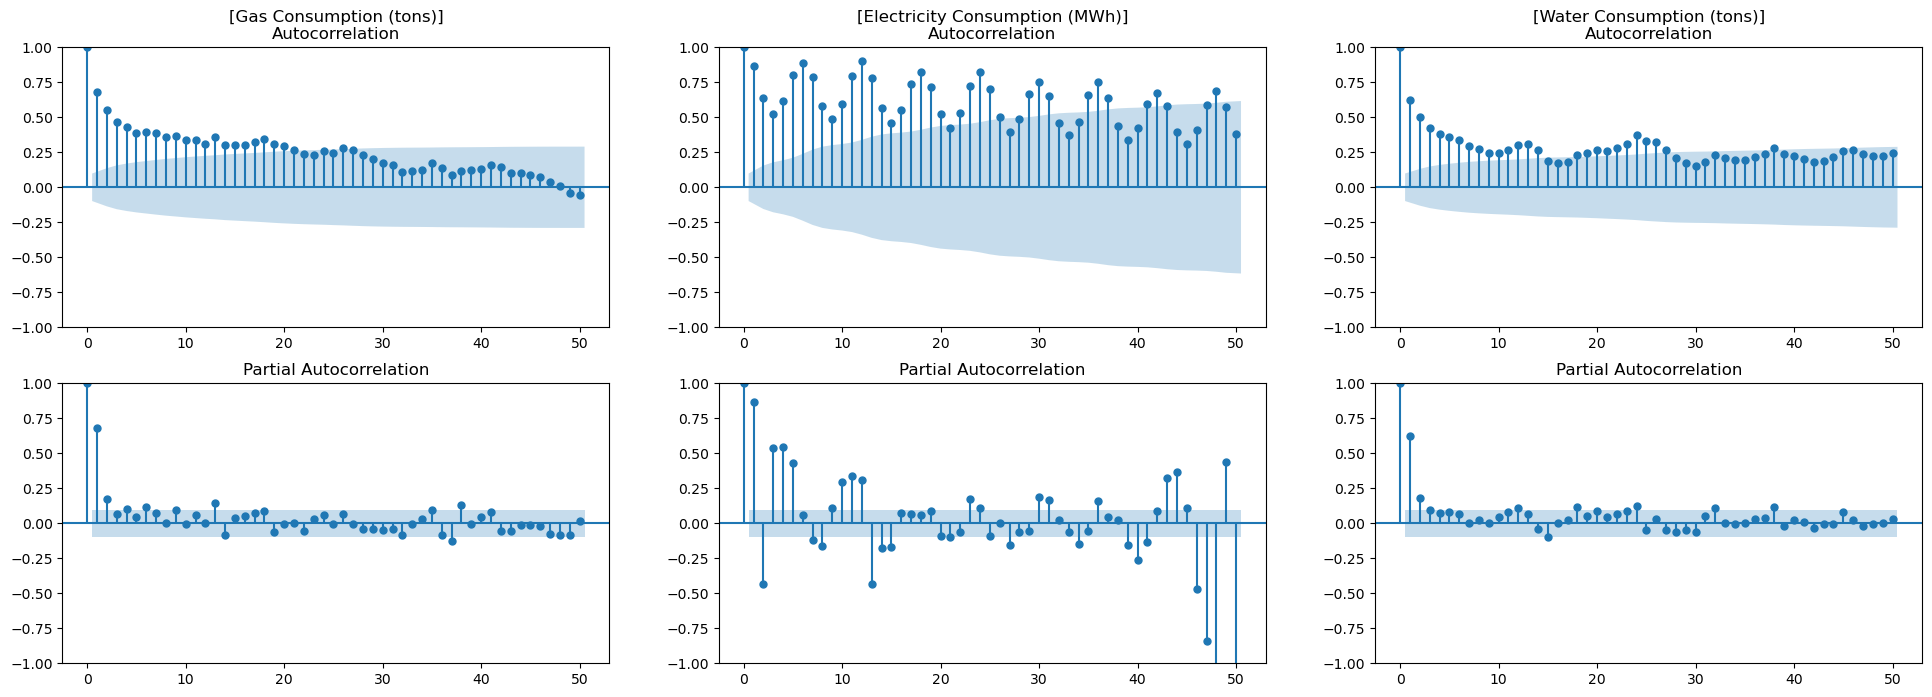

In [13]:
fig, axes = plt.subplots(2,3, figsize = (24,8))
for idx, feature in enumerate(features):
    plot_acf(df[feature], lags = 50, ax = axes[0, idx]) # Looks for MA(q)
    plot_pacf(df[feature], lags = 50, ax = axes[1, idx]) # Looks for AR(p)
    axes[0, idx].set_title("[{}]\nAutocorrelation".format(feature))
plt.show()

In [28]:
from plotly.subplots import make_subplots
features = ['Gas Consumption (tons)','Electricity Consumption (MWh)','Water Consumption (tons)']
fig = make_subplots(rows=3, cols=1)

for i, feature in enumerate(features):
    fig.add_trace(go.Scatter(x=df.index, y=df[feature], name=feature), row=i+1, col=1)
    # add name to subplots
    fig.update_yaxes(title_text=feature, row=i+1, col=1)
    
fig.update_layout(height=800, width=1200, title_text="Time Series analysis of Gas, Electricity and Water Consumption")
fig.show()


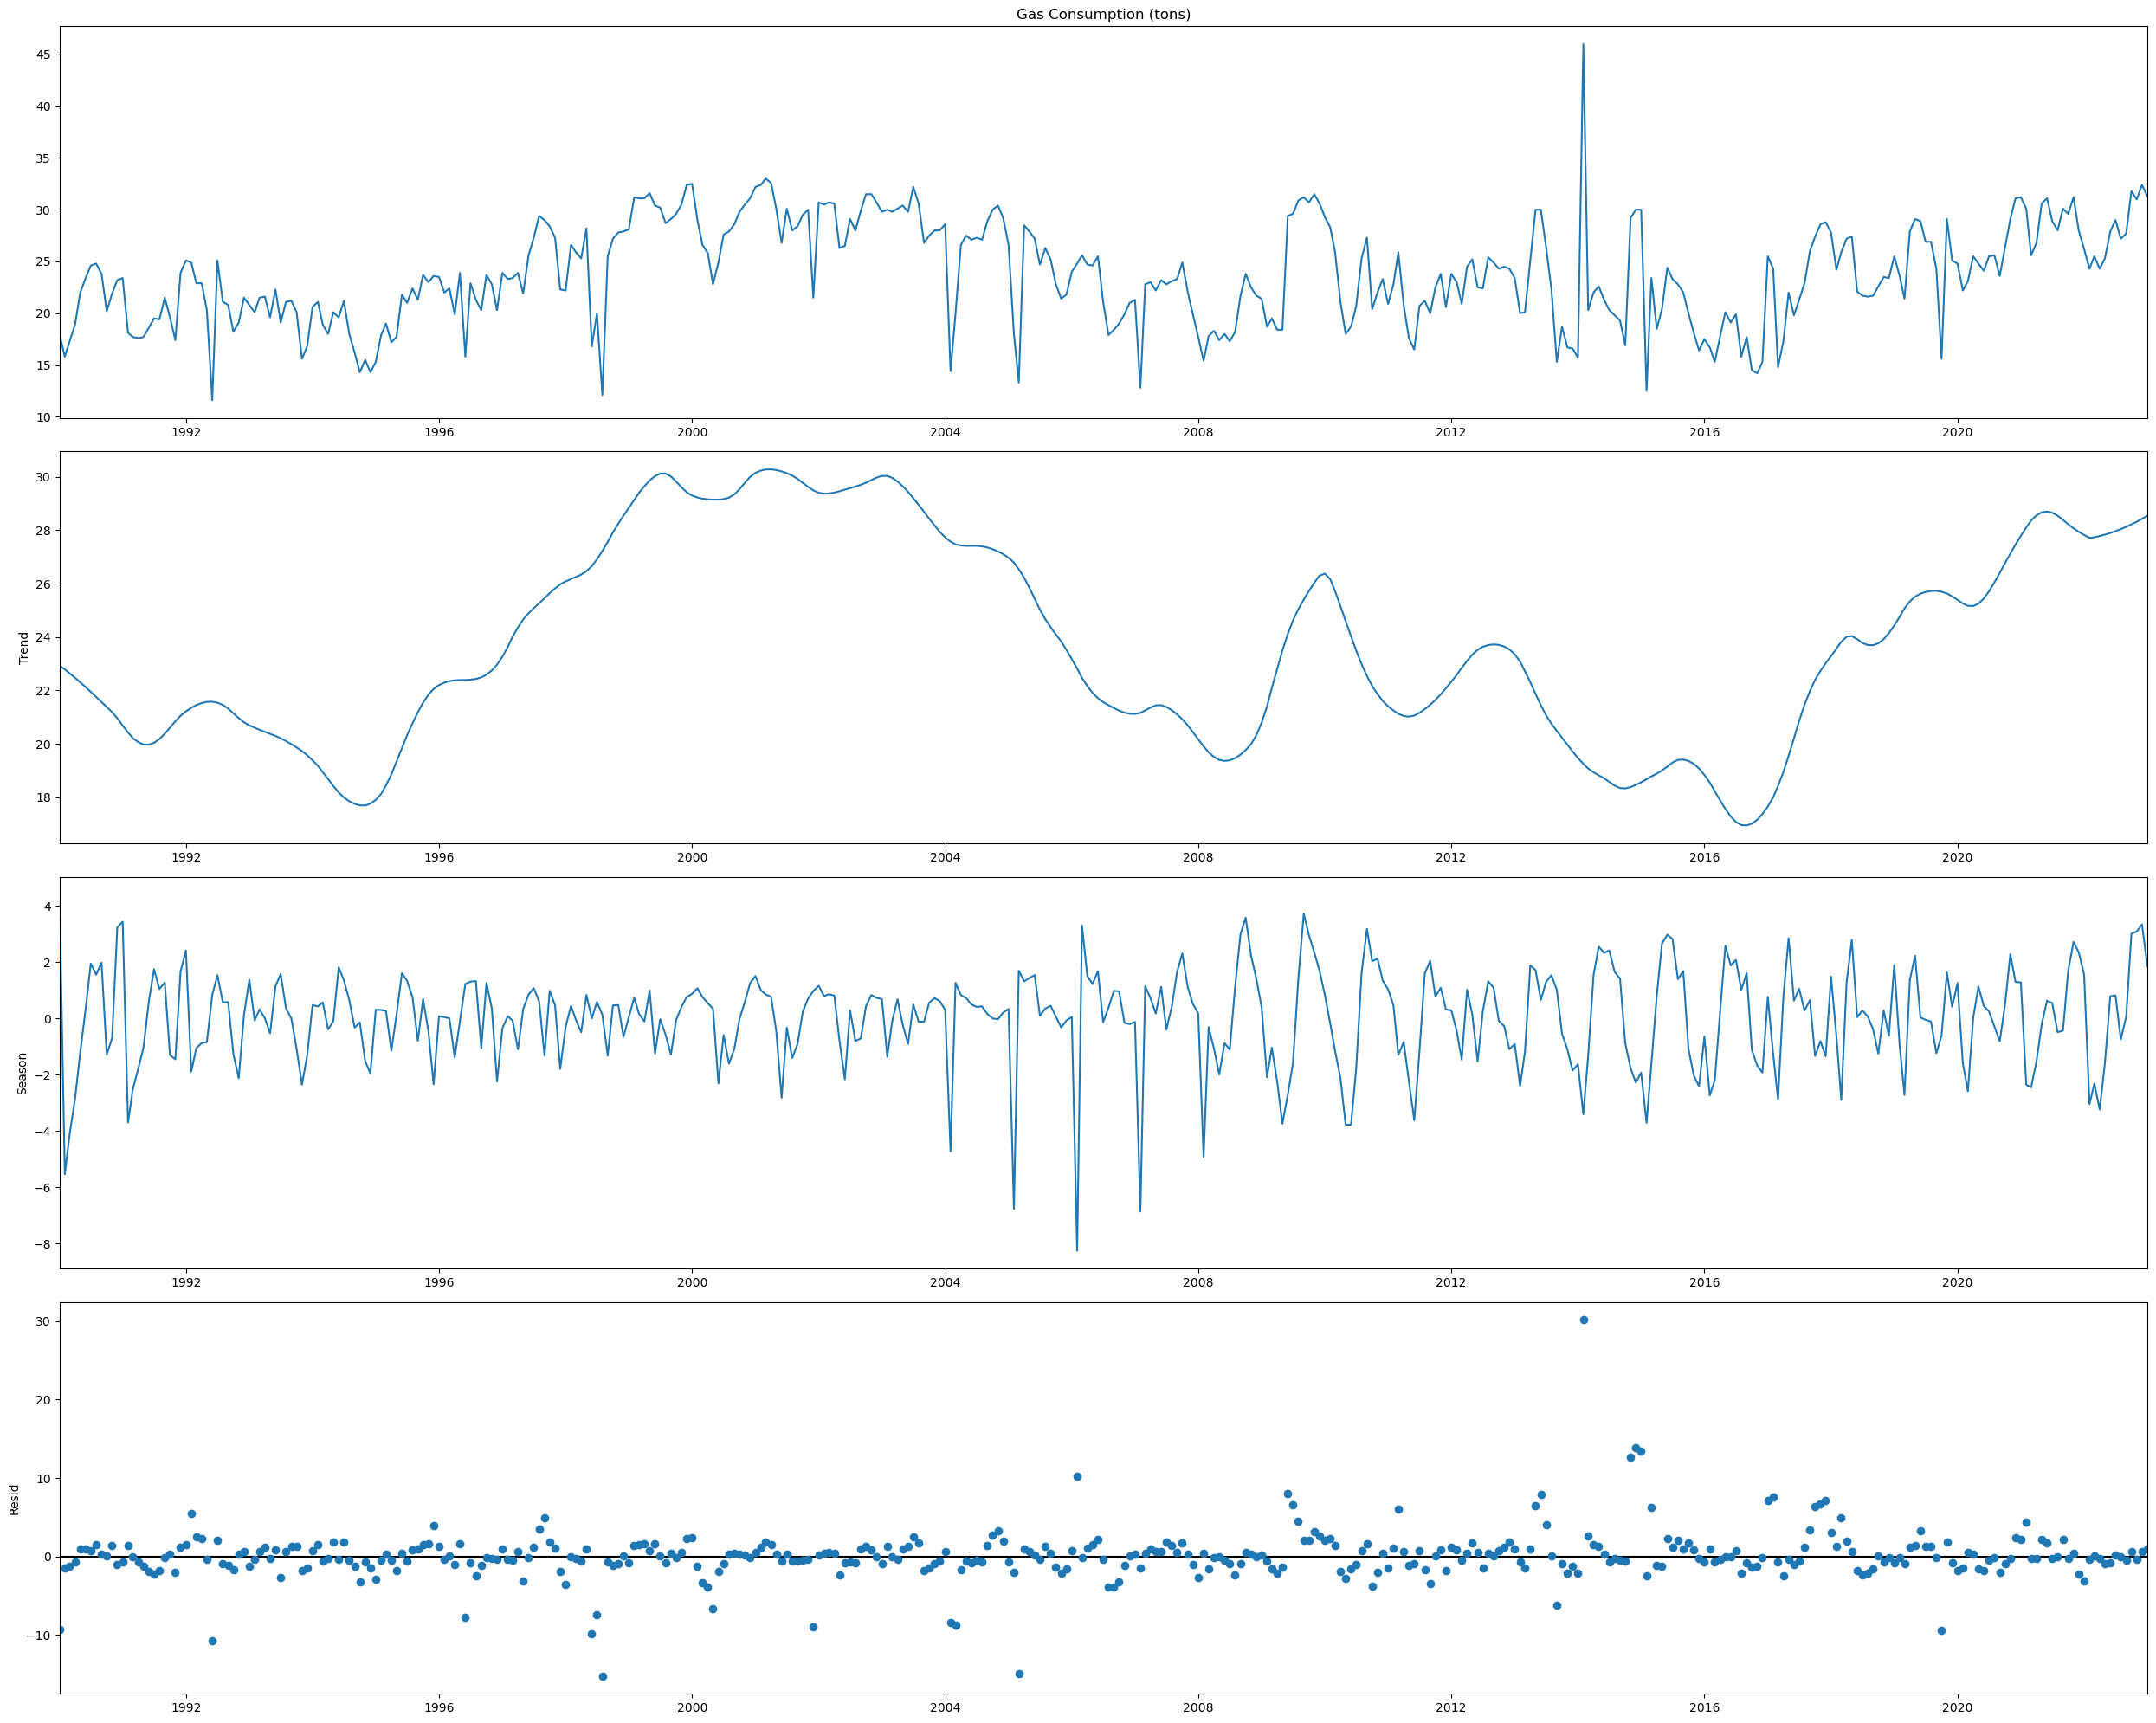

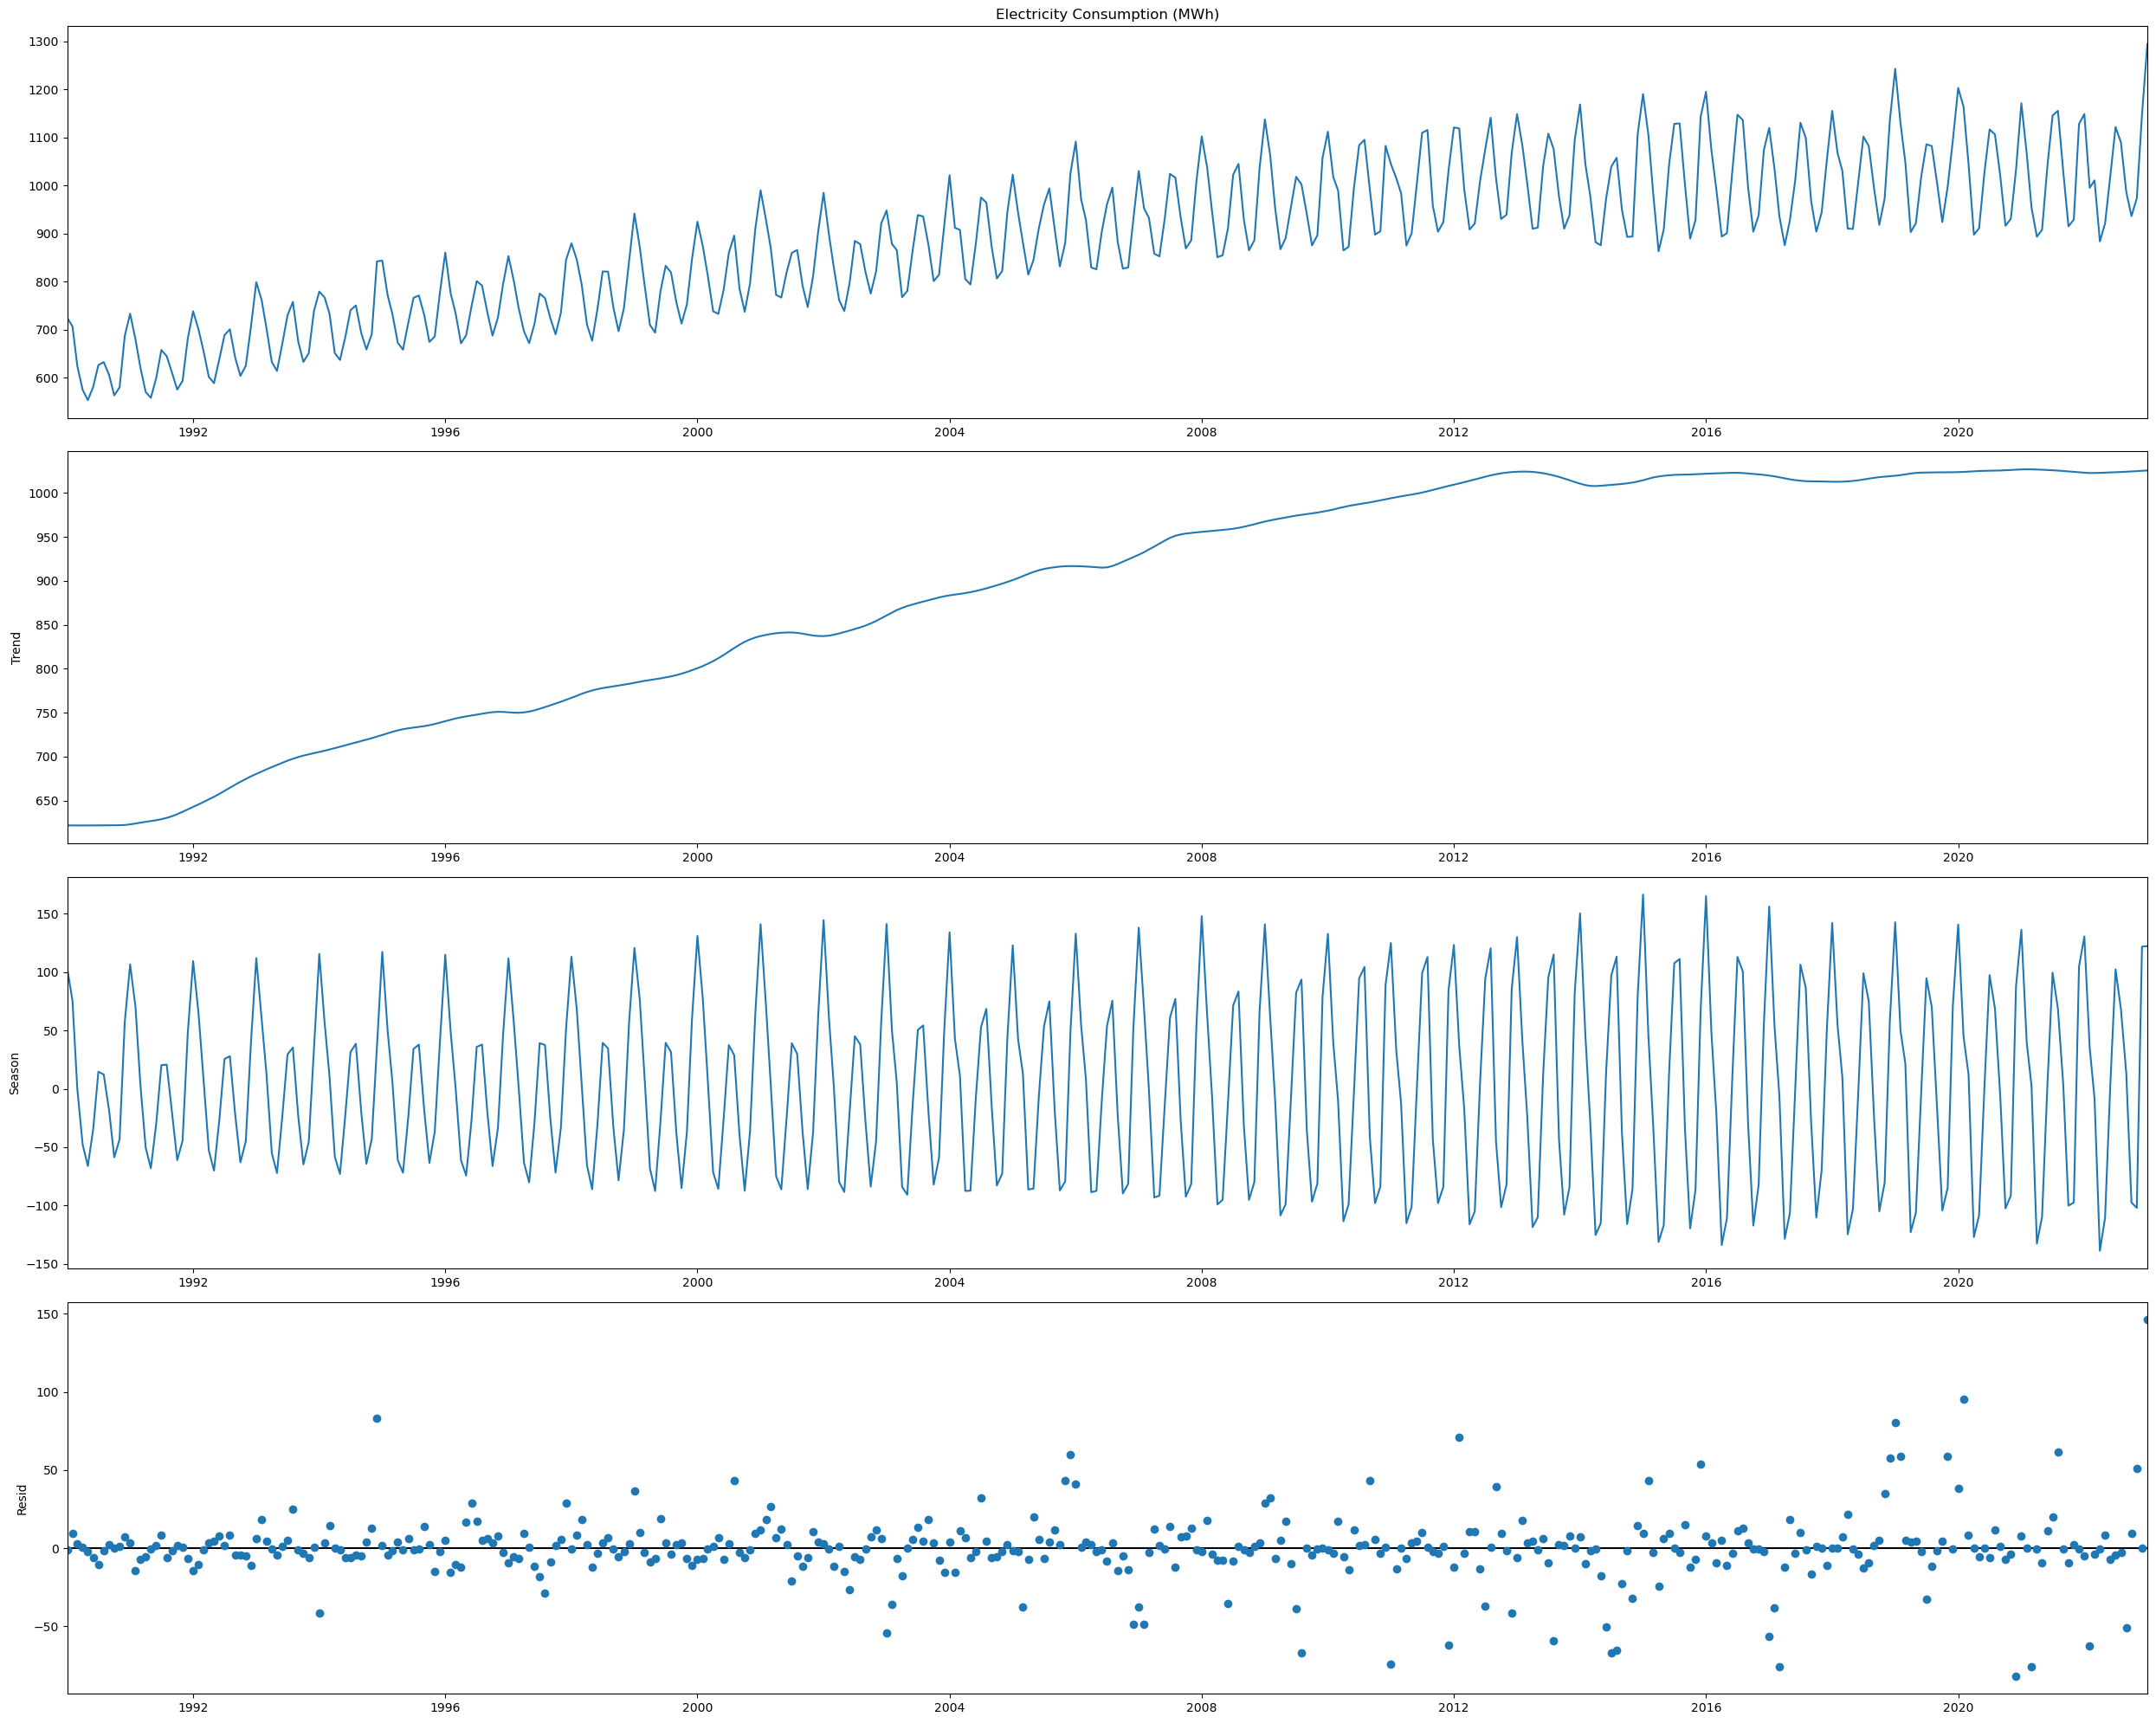

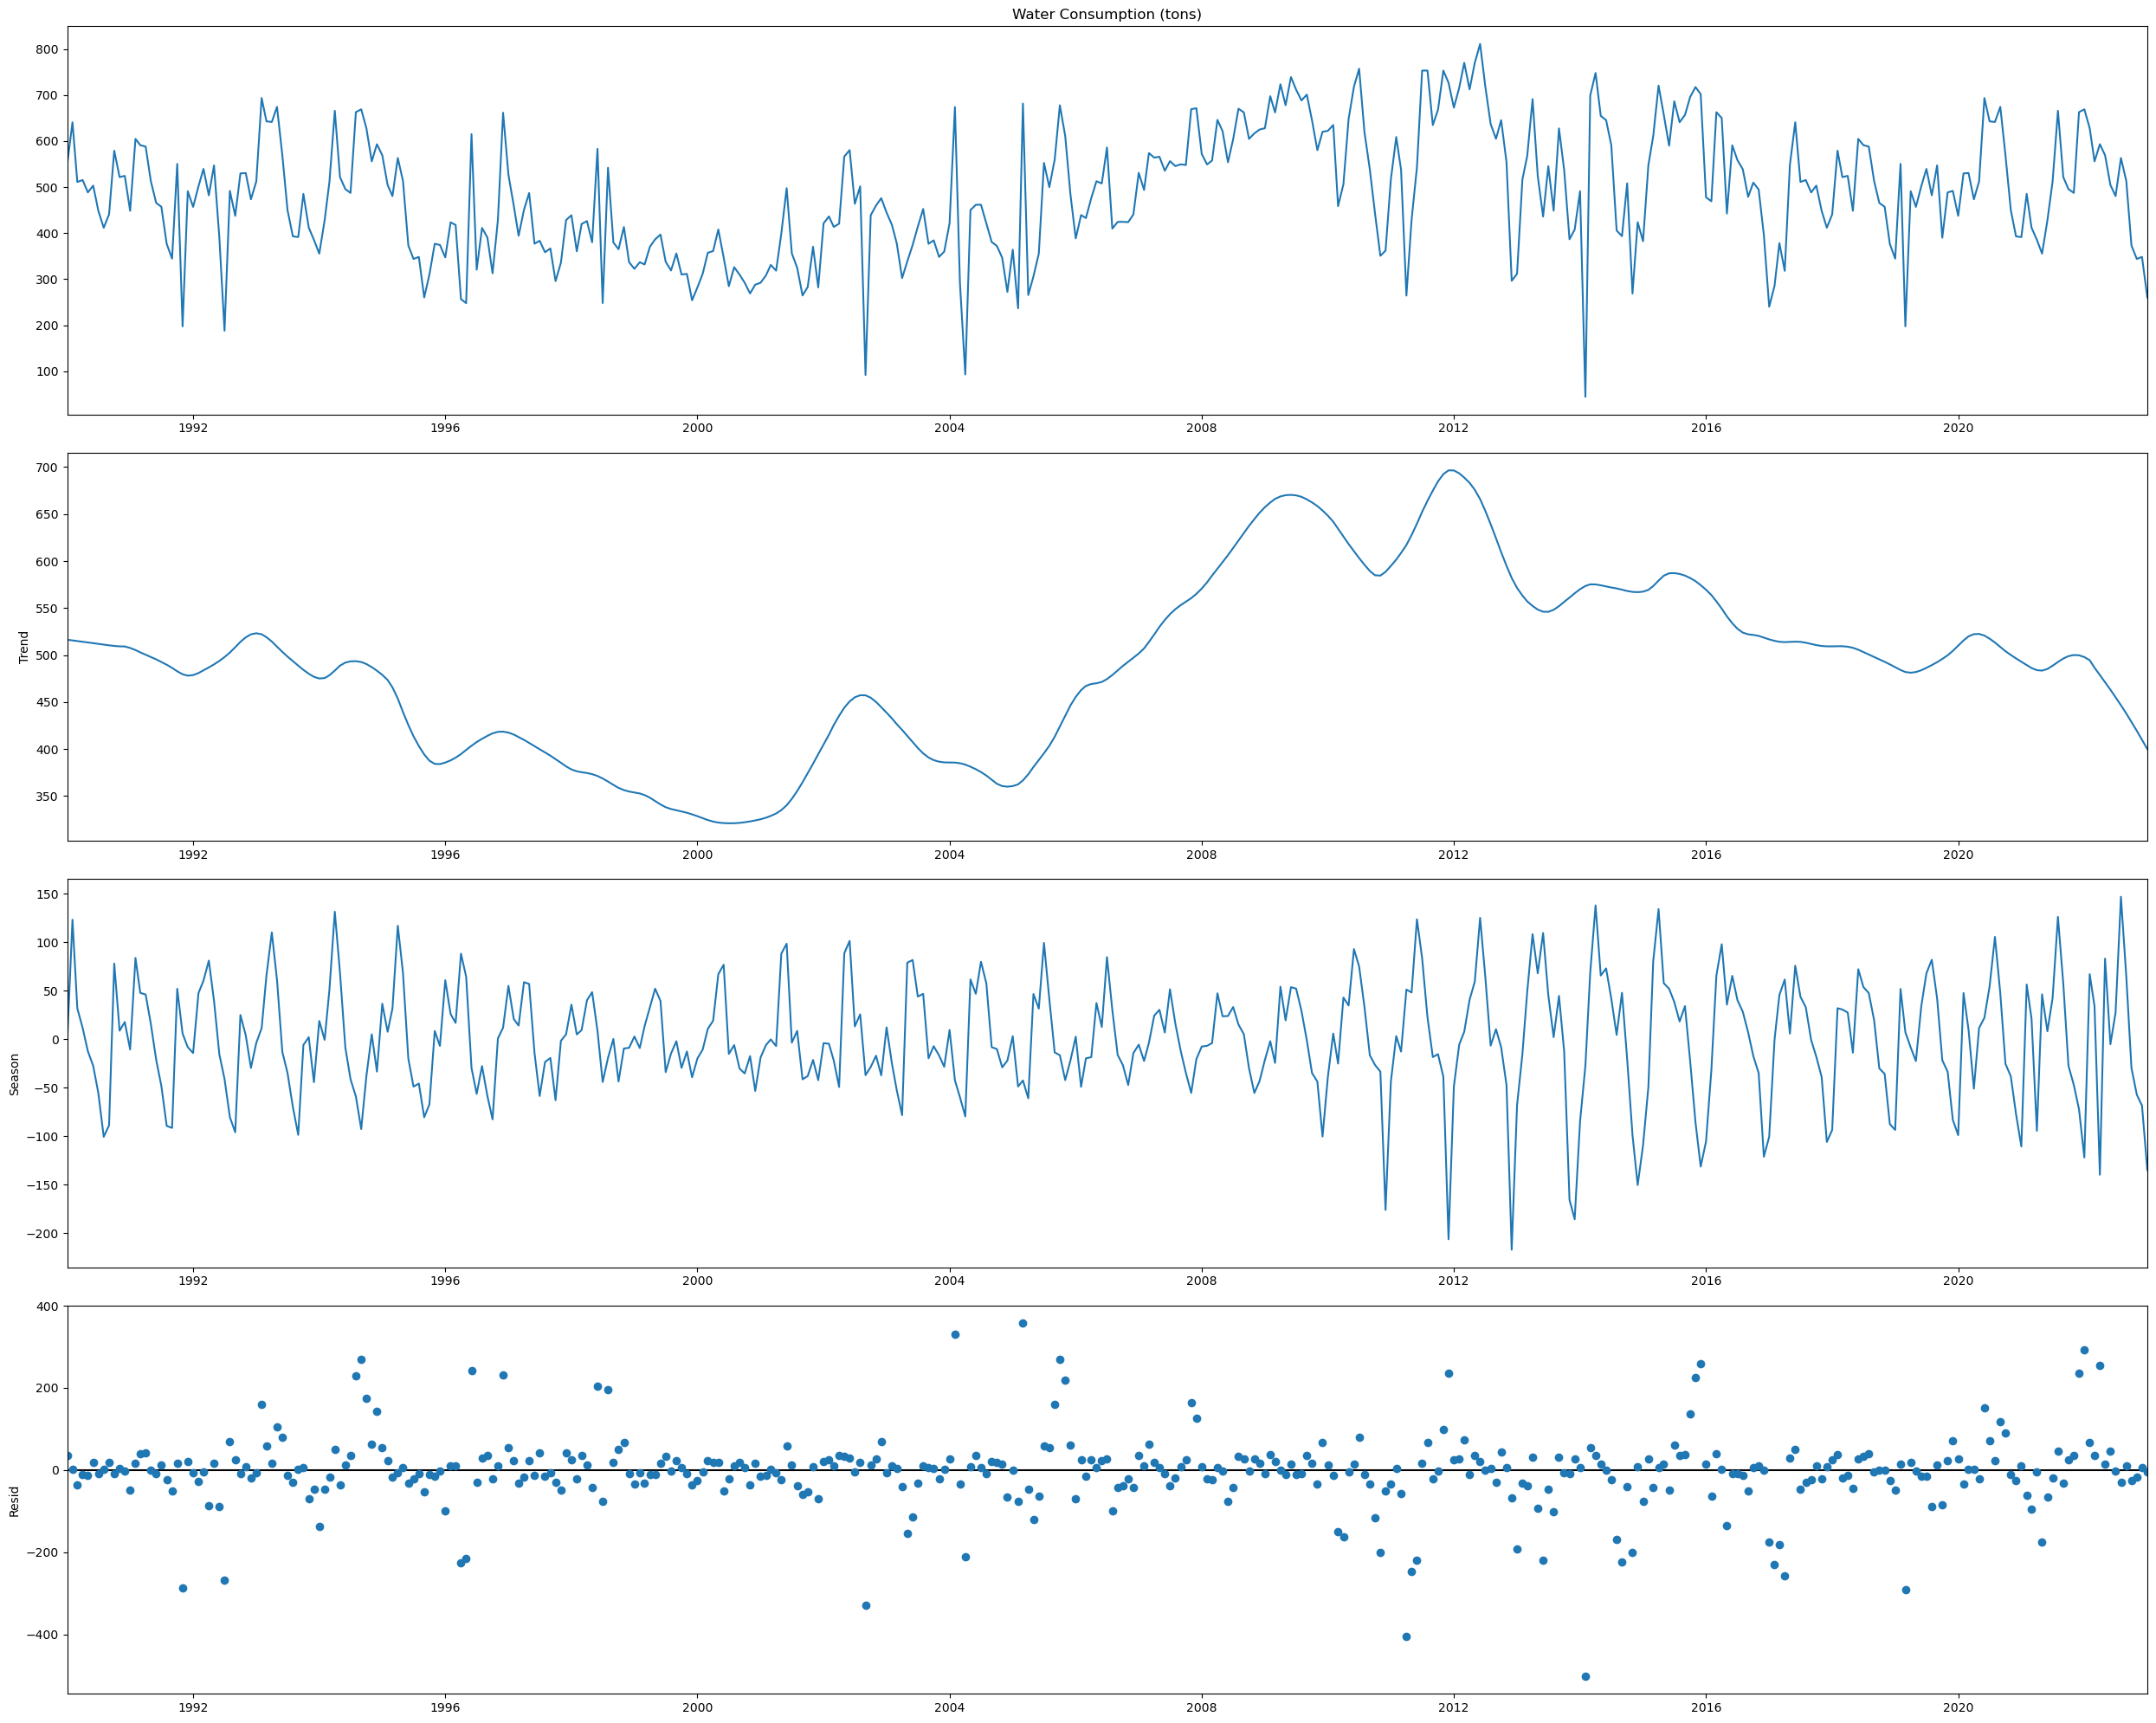

In [17]:
for feature in features:
    res = STL(df[feature], robust=True).fit()
    res.plot()
    plt.show()
    plt.rcParams['figure.figsize'] = (25, 20)
    
# res = STL(df['Electricity Consumption (MWh)'], robust=True).fit()
# res.plot()
# plt.show()



The Granger causality test is a statistical hypothesis test for determining whether one time series is useful in forecasting another. In this paper, we adapted the granger causality test to validate that the features are related in forecasting the energy consumption.

$H_{0}$ : X does not granger cause Y

$H_{1}$ : X does granger cause Y

From the table below, we observed that the H0 is rejected (p-value<0.05) for O3 and HC for both temperature and relative humidity.This shows that the temperature and relative humidity is useful in predicting O3 and HC. Otherwise, H0 is not rejected for CO and NO2 as the p-value is >a=0.05.This means that the temperature and relative humidity may not be related/useful in predicting CO and NO2.

In [30]:
from statsmodels.tsa.stattools import grangercausalitytests

relate = pd.DataFrame({'Gas1': [], 'Gas2': [], 'p-value': []})

for i in range(len(features)):
    for j in range(i+1, len(features)):
        gas1 = features[i]
        gas2 = features[j]
        result = grangercausalitytests(df[[gas1, gas2]], maxlag=1)
        p_value = result[1][0]['ssr_ftest'][1]
        relate = relate.append({'Gas1': gas1, 'Gas2': gas2, 'p-value': p_value}, ignore_index=True)
        if p_value < 0.05:
            print(f'{gas1} Granger causes {gas2}')
        else:
            print(f'{gas1} does not Granger cause {gas2}')

print(relate)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0381  , p=0.8454  , df_denom=393, df_num=1
ssr based chi2 test:   chi2=0.0384  , p=0.8447  , df=1
likelihood ratio test: chi2=0.0384  , p=0.8447  , df=1
parameter F test:         F=0.0381  , p=0.8454  , df_denom=393, df_num=1
Gas Consumption (tons) does not Granger cause Electricity Consumption (MWh)

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0179  , p=0.8935  , df_denom=393, df_num=1
ssr based chi2 test:   chi2=0.0181  , p=0.8930  , df=1
likelihood ratio test: chi2=0.0181  , p=0.8930  , df=1
parameter F test:         F=0.0179  , p=0.8935  , df_denom=393, df_num=1
Gas Consumption (tons) does not Granger cause Water Consumption (tons)

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3296  , p=0.5662  , df_denom=393, df_num=1
ssr based chi2 test:   chi2=0.3321  , p=0.5644  , df=1
likelihood ratio test: chi2=0.3319  , p=0.5645  , df=1
parameter F test:   

C:\Users\Fitri\AppData\Local\Temp\ipykernel_8532\2237403048.py:11: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Fitri\AppData\Local\Temp\ipykernel_8532\2237403048.py:11: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Fitri\AppData\Local\Temp\ipykernel_8532\2237403048.py:11: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



## Checking For Cointegration
Even though cointegration requires 2 non stationary features, as water is ambiguous, I feel that we should test just in case to view whether there is cointegration.

In [63]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

for i in range(len(features)):
    for j in range(i+1, len(features)):
        gas1 = features[i]
        gas2 = features[j]
        data = df[['Gas Consumption (tons)', 'Electricity Consumption (MWh)', 'Water Consumption (tons)']]
        result = coint_johansen(data, det_order = 0, k_ar_diff=1)

        p_values = result.lr1
        significance_level = 0.05
        significant_p_values = p_values < significance_level

        if any(significant_p_values):
            print("There is evidence of cointegration among the variables.")
            for i, p_value in enumerate(p_values):
                if p_value < significance_level:
                    print(f"Variable {i+1}: p-value = {p_value:.4f} (significant)")
                else:
                    print(f"Variable {i+1}: p-value = {p_value:.4f}")
        else:
            print(f"There is no evidence of cointegration between {gas1} and {gas2}")

There is no evidence of cointegration between Gas Consumption (tons) and Electricity Consumption (MWh)
There is no evidence of cointegration between Gas Consumption (tons) and Water Consumption (tons)
There is no evidence of cointegration between Electricity Consumption (MWh) and Water Consumption (tons)


[DATE
1990-01-01    False
1990-02-01    False
1990-03-01    False
1990-04-01    False
1990-05-01    False
              ...  
2022-09-01    False
2022-10-01     True
2022-11-01    False
2022-12-01    False
2023-01-01    False
Name: Gas Consumption (tons), Length: 397, dtype: bool, DATE
1990-01-01    False
1990-02-01    False
1990-03-01    False
1990-04-01    False
1990-05-01    False
              ...  
2022-09-01    False
2022-10-01    False
2022-11-01    False
2022-12-01    False
2023-01-01    False
Name: Electricity Consumption (MWh), Length: 397, dtype: bool, DATE
1990-01-01    False
1990-02-01    False
1990-03-01    False
1990-04-01    False
1990-05-01    False
              ...  
2022-09-01    False
2022-10-01     True
2022-11-01     True
2022-12-01    False
2023-01-01    False
Name: Water Consumption (tons), Length: 397, dtype: bool]


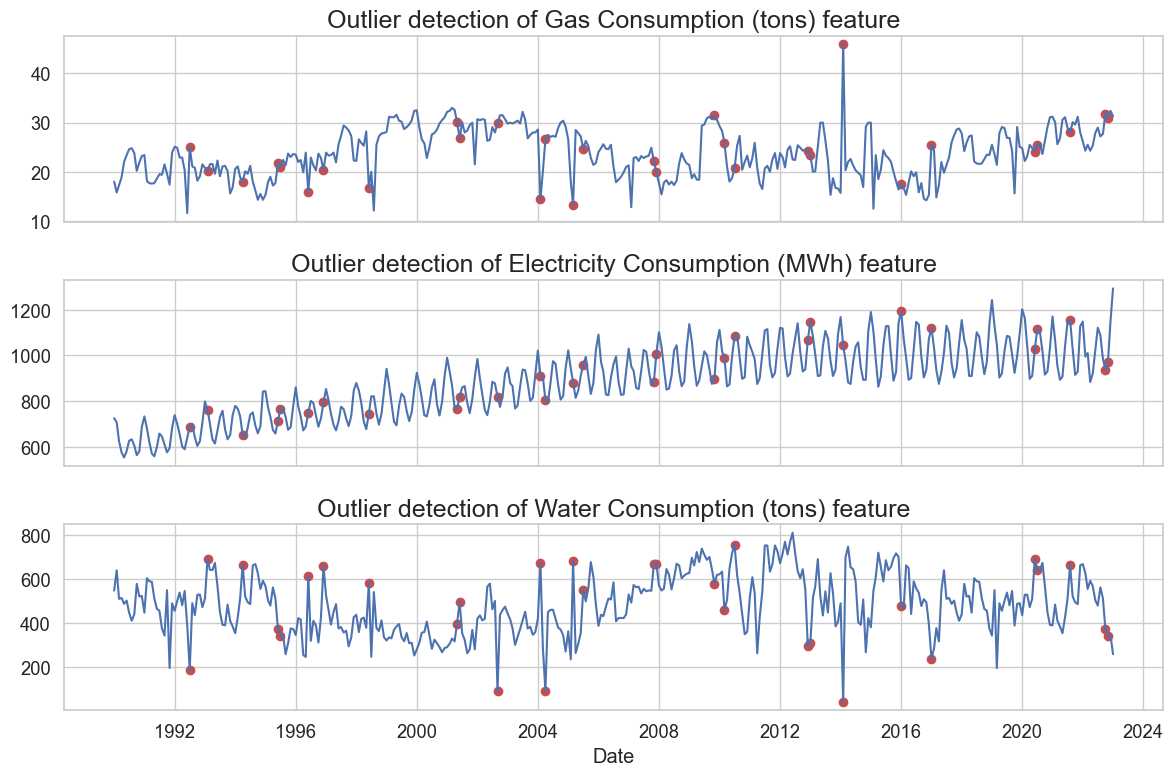

In [70]:
# Set the window size for the rolling IQR
window_size = 10
outliers_list = []

rolling_iqr_gas = data['Gas Consumption (tons)'].rolling(window=window_size).quantile(0.75) - data['Gas Consumption (tons)'].rolling(window=window_size).quantile(0.25)
rolling_iqr_electricity = data['Electricity Consumption (MWh)'].rolling(window=window_size).quantile(0.75) - data['Electricity Consumption (MWh)'].rolling(window=window_size).quantile(0.25)
rolling_iqr_water = data['Water Consumption (tons)'].rolling(window=window_size).quantile(0.75) - data['Water Consumption (tons)'].rolling(window=window_size).quantile(0.25)

lower_bound_gas = data['Gas Consumption (tons)'].rolling(window=window_size).quantile(0.25) - 1.5 * rolling_iqr_gas
upper_bound_gas = data['Gas Consumption (tons)'].rolling(window=window_size).quantile(0.75) + 1.5 * rolling_iqr_gas

lower_bound_electricity = data['Electricity Consumption (MWh)'].rolling(window=window_size).quantile(0.25) - 1.5 * rolling_iqr_electricity
upper_bound_electricity = data['Electricity Consumption (MWh)'].rolling(window=window_size).quantile(0.75) + 1.5 * rolling_iqr_electricity

lower_bound_water = data['Water Consumption (tons)'].rolling(window=window_size).quantile(0.25) - 1.5 * rolling_iqr_water
upper_bound_water = data['Water Consumption (tons)'].rolling(window=window_size).quantile(0.75) + 1.5 * rolling_iqr_water

outliers_gas = (data['Gas Consumption (tons)'] < lower_bound_gas) | (data['Gas Consumption (tons)'] > upper_bound_gas)
outliers_electricity = (data['Electricity Consumption (MWh)'] < lower_bound_electricity) | (data['Electricity Consumption (MWh)'] > upper_bound_electricity)
outliers_water = (data['Water Consumption (tons)'] < lower_bound_water) | (data['Water Consumption (tons)'] > upper_bound_water)

for feature in features:
    rolling_iqr = data[feature].rolling(window=window_size).quantile(0.75) - data[feature].rolling(window=window_size).quantile(0.25)
    lower_bound = data[feature].rolling(window=window_size).quantile(0.25) - 1.5 * rolling_iqr
    upper_bound = data[feature].rolling(window=window_size).quantile(0.75) + 1.5 * rolling_iqr
    outliers = (data[feature] < lower_bound) | (data[feature] > upper_bound)
    outliers_list.append(outliers)
print(outliers_list)

# # Create a figure and axes
# fig, axes = plt.subplots(len(outliers_list), 1, figsize=(10, len(outliers_list) * 6))

# for i, feature in enumerate(outliers_list):
#     ax = axes[i]
#     ax.plot(data.index, data[features[i]])
#     ax.scatter(x=feature.index, y=data[features[i]][feature], color='r')
#     ax.set_title(f'Outlier detection of {features[i]} feature', fontsize=18)

# # Set the x-axis label
# axes[-1].set_xlabel('Date')

# # Adjust the spacing between subplots
# fig.tight_layout()

# # Show the plot
# plt.show()

fig, axes = plt.subplots(len(features), 1, figsize=(12, 8), sharex=True)

for i, feature in enumerate(outliers_list):
    ax = axes[i]
    ax.plot(data.index, data[features[i]])
    ax.scatter(x=data.index[outliers], y=data[features[i]][outliers], color='r')
    ax.set_title(f'Outlier detection of {features[i]} feature', fontsize=18)

plt.xlabel('Date')
plt.tight_layout()
plt.show()

<hr>

# References:

https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c<br>
https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/<br>